In [1]:
using Pkg
Pkg.activate("./")
Pkg.instantiate()

  Activating project at `~/Documents/UCL/3x2_analytical`
Precompiling project...
   2290.4 ms  ✓ OpenSSL
   3686.7 ms  ✓ HypergeometricFunctions
   2320.3 ms  ✓ HTTP
   1294.8 ms  ✓ StatsFuns
   2476.2 ms  ✓ StatsFuns → StatsFunsChainRulesCoreExt
   3293.3 ms  ✓ Distributions
    939.4 ms  ✓ Distributions → DistributionsChainRulesCoreExt
    942.0 ms  ✓ Distributions → DistributionsTestExt
  29094.5 ms  ✓ Qt6ShaderTools_jll
   1088.3 ms  ✓ Qt6Declarative_jll
    650.7 ms  ✓ Qt6Wayland_jll
  61471.3 ms  ✓ Plots → UnitfulExt
   2308.8 ms  ✓ Plots → FileIOExt
  13 dependencies successfully precompiled in 96 seconds. 253 already precompiled.


In [2]:
using LinearAlgebra
using ForwardDiff
using Plots
using LimberJack
using CSV
using YAML
using NPZ
using DataFrames
using PythonCall
sacc = pyimport("sacc");

[ Info: Precompiling ForwardDiff [f6369f11-7733-5829-9624-2563aa707210] (cache misses: mismatched flags (2))
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling ForwardDiffStaticArraysExt [b74fd6d0-9da7-541f-a07d-1b6af30a262f] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling SpecialFunctionsChainRulesCoreExt [9eb7bdd4-e44c-55fc-b9cc-1a32cb715188] (cache misses: wrong dep version loaded (2), mismatched flags (2))
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c] (cache misses: wrong dep version loaded (2))
[ Info: Precompiling YAML [ddb6d928-2868-570f-bddf-ab3f9cf99eb6] (cache misses: wrong dep version loaded (2))


# Judith's Chain

In [3]:
using DelimitedFiles
chain = readdlm("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/cosmodc2_3x2pt_fourier_lcdm.txt");

In [4]:
chain_vals = chain[200:end, :]
param_names = chain[1, :];

post = chain_vals[:, 32]
index_of_min = argmax(post)
row_with_min = chain_vals[index_of_min, :]
Wm = row_with_min[1]+row_with_min[2]
Wb = row_with_min[2]
h0 = row_with_min[5]
ns = row_with_min[3]
s8 = row_with_min[29]
best_params = [Wm, Wb, h0, s8, ns]
print(best_params)

nuisances = Dict(
    "lens_0_b" => row_with_min[13],
    "lens_1_b" => row_with_min[14],
    "lens_2_b" => row_with_min[15],
    "lens_3_b" => row_with_min[16],
    "lens_4_b" => row_with_min[17],
    "source_0_m" => row_with_min[8],
    "source_1_m" => row_with_min[9],
    "source_2_m" => row_with_min[10],
    "source_3_m" => row_with_min[11],
    "source_4_m" => row_with_min[12])

[0.2734714358876248, 0.042170616570847225, 0.7189925511925751, 0.7790071910238021, 0.9965136823002241]

Dict{String, Float64} with 10 entries:
  "lens_0_b"   => 0.879118
  "source_3_m" => -0.00278755
  "lens_2_b"   => 1.22145
  "source_2_m" => 0.00434908
  "lens_4_b"   => 1.58909
  "source_0_m" => -0.00733846
  "source_4_m" => 0.000101118
  "lens_1_b"   => 1.05894
  "lens_3_b"   => 1.35065
  "source_1_m" => -0.00434667

In [5]:
function make_Cmod(dz_mean, dz_cov, data_cov, model; mode="AD")
    m = size(dz_cov)[1]
    n_cls = size(data_cov)[1]
    T = zeros(n_cls, m)

    if mode == "AD"
        println("Using automatic differentiation to compute T")
        T = ForwardDiff.jacobian(model, dz_mean)
    elseif mode == "FD"
        println("Using finite differences to compute T")
        d = 0.05
        for i in 1:m
            e = zeros(m)
            e[i] = d
            T[:, i] = (model(dz_mean.+e) .- model(dz_mean.-e)) ./ (2*d)
        end
    end
    TPT = T * dz_cov * T'
    Cmod = Symmetric(data_cov + TPT)
    return Cmod
end

make_Cmod (generic function with 1 method)

In [6]:
#dz_err_wlwl = [0.017, 0.017, 0.013, 0.015]
#dz_err_gcgc = [0.007, 0.007, 0.006, 0.01, 0.01]
#dz_err_3x2 = [dz_err_wlwl; dz_err_gcgc]

#dz_cov_wlwl = diagm(dz_err_wlwl.^2)
#dz_cov_gcgc = diagm(dz_err_gcgc.^2)
#dz_cov_3x2 = diagm(dz_err_3x2.^2);

## WLWL

In [7]:

method = "bpz"
sacc_path = "./data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "./data/CosmoDC2/wlwl.yml"
nz_path = string("./data/CosmoDC2/image_nzs_", method, "_priors/")
dz_path = string("./data/CosmoDC2/image_dz_", method, "_priors/dz_prior.npz")
fake_data_path = string("./data/CosmoDC2/CosmoDC2_wlwl_theory_photo_", method, "_best.csv")

fake_data = CSV.read(fake_data_path, DataFrame)
fake_data = fake_data.theory[1:end-1]

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))
zs_k0, nz_k0 = nz_source_0["z"], nz_source_0["dndz"]
zs_k1, nz_k1 = nz_source_1["z"], nz_source_1["dndz"]
zs_k2, nz_k2 = nz_source_2["z"], nz_source_2["dndz"]
zs_k3, nz_k3 = nz_source_3["z"], nz_source_3["dndz"]
zs_k4, nz_k4 = nz_source_4["z"], nz_source_4["dndz"]
mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)

dz_prior = npzread(dz_path)
dz_mean, dz_cov = dz_prior["mean"], dz_prior["cov"]
dz_mean_wlwl = dz_mean[1:10]
dz_cov_wlwl = dz_cov[1:10, 1:10]
dz_chol_wlwl = cholesky(dz_cov_wlwl).U'

meta_wlwl, files_wlwl = make_data(sacc_file, yaml_file;
                        nz_source_0=nz_source_0,
                        nz_source_1=nz_source_1,
                        nz_source_2=nz_source_2,
                        nz_source_3=nz_source_3,
                        nz_source_4=nz_source_4)

meta_wlwl.types = [    
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

source_0 source_0 15
source_1 source_0 15
source_1 source_1 15
source_2 source_0 15
source_2 source_1 15
source_2 source_2 15
source_3 source_0 15
source_3 source_1 15
source_3 source_2 15
source_3 source_3 15
source_4 source_0 15
source_4 source_1 15
source_4 source_2 15
source_4 source_3 15
source_4 source_4 15
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_source_4


5-element Vector{String}:
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

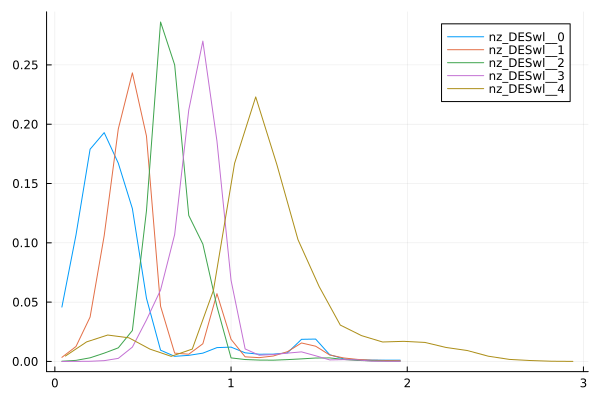

In [8]:
plot(files_wlwl["nz_source_0"][1], files_wlwl["nz_source_0"][2], label="nz_DESwl__0")
plot!(files_wlwl["nz_source_1"][1], files_wlwl["nz_source_1"][2], label="nz_DESwl__1")
plot!(files_wlwl["nz_source_2"][1], files_wlwl["nz_source_2"][2], label="nz_DESwl__2")
plot!(files_wlwl["nz_source_3"][1], files_wlwl["nz_source_3"][2], label="nz_DESwl__3")
plot!(files_wlwl["nz_source_4"][1], files_wlwl["nz_source_4"][2], label="nz_DESwl__4")

In [9]:
function model_wlwl(alphas; meta=meta_wlwl, files=files_wlwl)
    SnWs = dz_mean_wlwl .+ dz_chol_wlwl * alphas
    dzs = [SnWs[1], SnWs[3], SnWs[5], SnWs[7], SnWs[9]]
    wzs = [SnWs[2], SnWs[4], SnWs[6], SnWs[8], SnWs[10]]
    source_0_zs = @.((zs_k0-mu_k0)/wzs[1] + mu_k0 + dzs[1])
    source_1_zs = @.((zs_k1-mu_k1)/wzs[2] + mu_k1 + dzs[2])
    source_2_zs = @.((zs_k2-mu_k2)/wzs[3] + mu_k2 + dzs[3])
    source_3_zs = @.((zs_k3-mu_k3)/wzs[4] + mu_k3 + dzs[4])
    source_4_zs = @.((zs_k4-mu_k4)/wzs[5] + mu_k4 + dzs[5])

    nuisances = Dict(
        "source_0_b"    => 0.879118,
        "source_1_b"    => 1.05894,
        "source_2_b"    => 1.22145,
        "source_3_b"    => 1.35065,
        "source_4_b"    => 1.58909,
        "source_0_zs"   => source_0_zs,
        "source_1_zs"   => source_1_zs,
        "source_2_zs"   => source_2_zs,
        "source_3_zs"   => source_3_zs,
        "source_4_zs"   => source_4_zs,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)
        
    cosmo = Cosmology(
        Ωm=best_params[1],
        Ωb=best_params[2],
        h=best_params[3],
        σ8=best_params[4],
        ns=best_params[5],
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [10]:
Cmod_wlwl_FD = make_Cmod(dz_mean_wlwl, diagm(ones(10)), meta_wlwl.cov, model_wlwl; mode="FD")
Cmod_wlwl_AD = make_Cmod(dz_mean_wlwl, diagm(ones(10)), meta_wlwl.cov, model_wlwl; mode="AD")

Using finite differences to compute T
Using automatic differentiation to compute T


225×225 Symmetric{Float64, Matrix{Float64}}:
  1.02193e-16  -1.92579e-17   4.99644e-18  …  -1.76416e-21  -1.1825e-21
 -1.92579e-17   1.95076e-17  -1.99413e-18     -1.2764e-21   -8.55409e-22
  4.99644e-18  -1.99413e-18   4.97498e-18     -8.72556e-22  -5.8477e-22
  4.62995e-19   9.17475e-19  -1.25024e-19     -5.77159e-22  -3.8679e-22
  5.8268e-19    3.51721e-19   3.03e-19        -3.7082e-22   -2.48505e-22
  3.4419e-19    2.46841e-19   1.6593e-19   …  -2.39342e-22  -1.60392e-22
  2.28334e-19   1.612e-19     1.11305e-19     -1.58002e-22  -1.05883e-22
  1.52653e-19   1.09364e-19   7.52197e-20     -1.07304e-22  -7.19077e-23
  1.05496e-19   7.58451e-20   5.2134e-20      -7.45909e-23  -4.99851e-23
  7.36796e-20   5.31059e-20   3.64858e-20     -5.22909e-23  -3.50411e-23
  5.10261e-20   3.68114e-20   2.52875e-20  …  -3.62488e-23  -2.42906e-23
  3.43282e-20   2.47695e-20   1.70157e-20     -2.43632e-23  -1.63258e-23
  2.21195e-20   1.59554e-20   1.09623e-20     -1.56671e-23  -1.04924e-23
  ⋮      

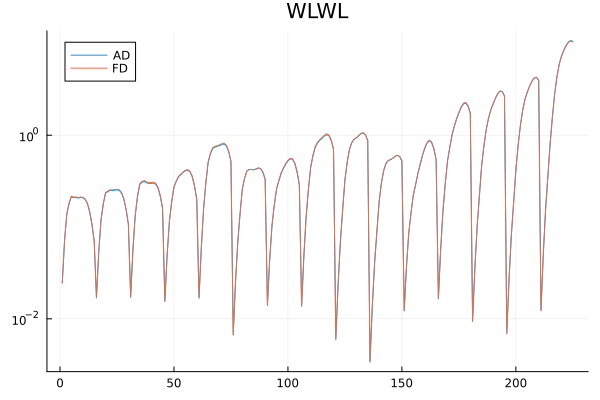

In [11]:
plot(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_AD)) ./ diag(meta_wlwl.cov), label="AD", title="WLWL")
plot!(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_FD)) ./ diag(meta_wlwl.cov), yscale=:log10, label="FD", title="WLWL")

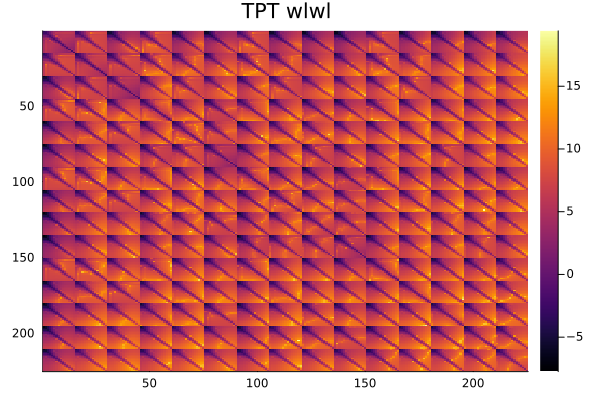

In [12]:
heatmap(log.(abs.((Cmod_wlwl_AD .- meta_wlwl.cov)./ meta_wlwl.cov)), title="TPT wlwl", yflip=true)

## GCGC

In [13]:
method = "bpz"
sacc_path = "./data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "./data/CosmoDC2/gcgc.yml"
nz_path = string("./data/CosmoDC2/image_nzs_", method, "_priors/")
dz_path = string("./data/CosmoDC2/image_dz_", method, "_priors/dz_prior.npz")
fake_data_path = string("./data/CosmoDC2/CosmoDC2_gcgc_theory_photo_", method, "_best.csv")

fake_data = CSV.read(fake_data_path, DataFrame)
fake_data = fake_data.theory[1:end-1]

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)

dz_prior = npzread(dz_path)
dz_mean, dz_cov = dz_prior["mean"], dz_prior["cov"]
dz_mean_gcgc = dz_mean[11:20]
dz_cov_gcgc = dz_cov[11:20, 11:20]
dz_chol_gcgc = cholesky(dz_cov_gcgc).U'

meta_gcgc, files_gcgc = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4)

meta_gcgc.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density"]

lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


5-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"

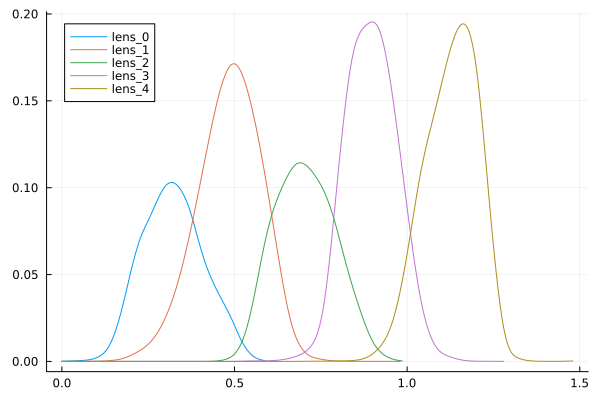

In [14]:
plot(files_gcgc["nz_lens_0"][1], files_gcgc["nz_lens_0"][2], label="lens_0")
plot!(files_gcgc["nz_lens_1"][1], files_gcgc["nz_lens_1"][2], label="lens_1")
plot!(files_gcgc["nz_lens_2"][1], files_gcgc["nz_lens_2"][2], label="lens_2")
plot!(files_gcgc["nz_lens_3"][1], files_gcgc["nz_lens_3"][2], label="lens_3")
plot!(files_gcgc["nz_lens_4"][1], files_gcgc["nz_lens_4"][2], label="lens_4")

In [17]:
function model_gcgc(alphas; meta=meta_gcgc, files=files_gcgc)
    SnWs = dz_mean_gcgc .+ dz_chol_gcgc * alphas
    dzs = [SnWs[1], SnWs[3], SnWs[5], SnWs[7], SnWs[9]]
    wzs = [SnWs[2], SnWs[4], SnWs[6], SnWs[8], SnWs[10]]
    lens_0_zs = @.((zs_k0-mu_k0)/wzs[1] + mu_k0 + dzs[1])
    lens_1_zs = @.((zs_k1-mu_k1)/wzs[2] + mu_k1 + dzs[2])
    lens_2_zs = @.((zs_k2-mu_k2)/wzs[3] + mu_k2 + dzs[3])
    lens_3_zs = @.((zs_k3-mu_k3)/wzs[4] + mu_k3 + dzs[4])
    lens_4_zs = @.((zs_k4-mu_k4)/wzs[5] + mu_k4 + dzs[5])

    nuisances = Dict(
        "source_0_b"    => 0.879118,
        "source_1_b"    => 1.05894,
        "source_2_b"    => 1.22145,
        "source_3_b"    => 1.35065,
        "source_4_b"    => 1.58909,
        "lens_0_zs"   => lens_0_zs,
        "lens_1_zs"   => lens_1_zs,
        "lens_2_zs"   => lens_2_zs,
        "lens_3_zs"   => lens_3_zs,
        "lens_4_zs"   => lens_4_zs,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118)
        
    cosmo = Cosmology(
        Ωm=best_params[1],
        Ωb=best_params[2],
        h=best_params[3],
        σ8=best_params[4],
        ns=best_params[5],
        tk_mode=:EisHu,
        pk_mode=:Halofit,
        nk=3000)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances,
        int_gc="none", smooth_gc=3)
end;

In [18]:
Cmod_gcgc_FD = make_Cmod(dz_mean_gcgc, diagm(ones(10)), meta_gcgc.cov, model_gcgc; mode="FD")
Cmod_gcgc_AD = make_Cmod(dz_mean_gcgc, diagm(ones(10)), meta_gcgc.cov, model_gcgc; mode="AD");

Using finite differences to compute T
Using automatic differentiation to compute T


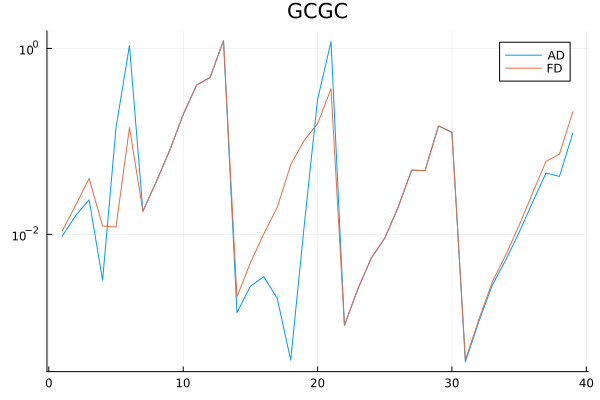

In [19]:
plot(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_AD)) ./ diag(meta_gcgc.cov), label="AD", title="GCGC")
plot!(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_FD)) ./ diag(meta_gcgc.cov), yscale=:log10, label="FD")

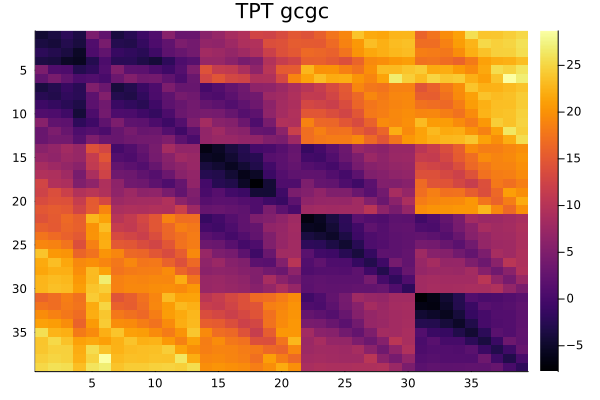

In [20]:
heatmap(log.(abs.((Cmod_gcgc_AD .- meta_gcgc.cov)./ meta_gcgc.cov)), title="TPT gcgc", yflip=true)

## 3x2

In [21]:
method = "bpz"
sacc_path = "./data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "./data/CosmoDC2/gcgc_gcwl_wlwl.yml"
nz_path = string("./data/CosmoDC2/image_nzs_", method, "_priors/")
dz_path = string("./data/CosmoDC2/image_dz_", method, "_priors/dz_prior.npz")
fake_data_path = string("./data/CosmoDC2/CosmoDC2_3x2_theory_photo_", method, "_best.csv")

fake_data = CSV.read(fake_data_path, DataFrame)
fake_data = fake_data.theory[1:end-1]

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["dndz"]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["dndz"]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["dndz"]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["dndz"]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")
#zs_k5, nz_k5 = LimberJack.nz_interpolate(zs_k5, nz_k5, 1000; mode="cubic")
#zs_k6, nz_k6 = LimberJack.nz_interpolate(zs_k6, nz_k6, 1000; mode="cubic")
#zs_k7, nz_k7 = LimberJack.nz_interpolate(zs_k7, nz_k7, 1000; mode="cubic")
#zs_k8, nz_k8 = LimberJack.nz_interpolate(zs_k8, nz_k8, 1000; mode="cubic")
#zs_k9, nz_k9 = LimberJack.nz_interpolate(zs_k9, nz_k9, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)
#nz_source_0 = Dict("z"=>zs_k5, "dndz"=>nz_k5)
#nz_source_1 = Dict("z"=>zs_k6, "dndz"=>nz_k6)
#nz_source_2 = Dict("z"=>zs_k7, "dndz"=>nz_k7)
#nz_source_3 = Dict("z"=>zs_k8, "dndz"=>nz_k8)
#nz_source_4 = Dict("z"=>zs_k9, "dndz"=>nz_k9)

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["dndz"]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["dndz"]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["dndz"]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["dndz"]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["dndz"]
mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)
mu_k5 = sum(zs_k5 .* nz_k5) / sum(nz_k5)
mu_k6 = sum(zs_k6 .* nz_k6) / sum(nz_k6)
mu_k7 = sum(zs_k7 .* nz_k7) / sum(nz_k7)
mu_k8 = sum(zs_k8 .* nz_k8) / sum(nz_k8)
mu_k9 = sum(zs_k9 .* nz_k9) / sum(nz_k9)

dz_prior = npzread(dz_path)
dz_mean_3x2, dz_cov_3x2 = dz_prior["mean"], dz_prior["cov"]
dz_chol_3x2 = cholesky(dz_cov_3x2).U'

meta_3x2, files_3x2 = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4,
                        nz_source_0=nz_source_0,
                        nz_source_1=nz_source_1,
                        nz_source_2=nz_source_2,
                        nz_source_3=nz_source_3,
                        nz_source_4=nz_source_4)

meta_3x2.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
source_0 lens_0 6
source_0 lens_1 7
source_0 lens_2 8
source_0 lens_3 9
source_0 lens_4 9
source_1 lens_0 8
source_1 lens_1 7
source_1 lens_2 8
source_1 lens_3 9
source_1 lens_4 9
source_2 lens_0 8
source_2 lens_1 7
source_2 lens_2 8
source_2 lens_3 9
source_2 lens_4 9
source_3 lens_0 8
source_3 lens_1 7
source_3 lens_2 8
source_3 lens_3 9
source_3 lens_4 9
source_4 lens_0 8
source_4 lens_1 7
source_4 lens_2 8
source_4 lens_3 9
source_4 lens_4 9
source_0 source_0 15
source_1 source_0 15
source_1 source_1 15
source_2 source_0 15
source_2 source_1 15
source_2 source_2 15
source_3 source_0 15
source_3 source_1 15
source_3 source_2 15
source_3 source_3 15
source_4 source_0 15
source_4 source_1 15
source_4 source_2 15
source_4 source_3 15
source_4 source_4 15
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_sour

10-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

In [22]:
function model_3x2(alphas; meta=meta_3x2, files=files_3x2)
    SnWs = dz_mean_3x2 .+ dz_chol_3x2 * alphas
    dzs = [SnWs[1], SnWs[3], SnWs[5], SnWs[7], SnWs[9],
           SnWs[11], SnWs[13], SnWs[15], SnWs[17], SnWs[19]]
    wzs = [SnWs[2], SnWs[4], SnWs[6], SnWs[8], SnWs[10],
           SnWs[12], SnWs[14], SnWs[16], SnWs[18], SnWs[20]]
    lens_0_zs   = @.((zs_k0-mu_k0)/wzs[1] + mu_k0 + dzs[1])
    lens_1_zs   = @.((zs_k1-mu_k1)/wzs[2] + mu_k1 + dzs[2])
    lens_2_zs   = @.((zs_k2-mu_k2)/wzs[3] + mu_k2 + dzs[3])
    lens_3_zs   = @.((zs_k3-mu_k3)/wzs[4] + mu_k3 + dzs[4])
    lens_4_zs   = @.((zs_k4-mu_k4)/wzs[5] + mu_k4 + dzs[5])
    source_0_zs = @.((zs_k5-mu_k5)/wzs[6] + mu_k5 + dzs[6])
    source_1_zs = @.((zs_k6-mu_k6)/wzs[7] + mu_k6 + dzs[7])
    source_2_zs = @.((zs_k7-mu_k7)/wzs[8] + mu_k7 + dzs[8])
    source_3_zs = @.((zs_k8-mu_k8)/wzs[9] + mu_k8 + dzs[9])
    source_4_zs = @.((zs_k9-mu_k9)/wzs[10] + mu_k9 + dzs[10])

    nuisances = Dict(
        "lens_0_b"    => 0.879118,
        "lens_1_b"    => 1.05894,
        "lens_2_b"    => 1.22145,
        "lens_3_b"    => 1.35065,
        "lens_4_b"    => 1.58909,
        "lens_0_zs"   => lens_0_zs,
        "lens_1_zs"   => lens_1_zs,
        "lens_2_zs"   => lens_2_zs,
        "lens_3_zs"   => lens_3_zs,
        "lens_4_zs"   => lens_4_zs,
        "source_0_m"  => -0.00733846,
        "source_1_m"  => -0.00434667,
        "source_2_m"  => 0.00434908,
        "source_3_m"  => -0.00278755,
        "source_4_m"  => 0.000101118,
        "source_0_zs" => source_0_zs,
        "source_1_zs" => source_1_zs,
        "source_2_zs" => source_2_zs,
        "source_3_zs" => source_3_zs,
        "source_4_zs" => source_4_zs)
        
    cosmo = Cosmology(
        Ωm=best_params[1],
        Ωb=best_params[2],
        h=best_params[3],
        σ8=best_params[4],
        ns=best_params[5],
        tk_mode=:EisHu,
        pk_mode=:Halofit,
        nk=3000)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances,
        int_gc="none", smooth_gc=3)
end;

In [23]:
Cmod_3x2_FD = make_Cmod(dz_mean_3x2, diagm(ones(20)), meta_3x2.cov, model_3x2; mode="FD");
Cmod_3x2_AD = make_Cmod(dz_mean_3x2, diagm(ones(20)), meta_3x2.cov, model_3x2; mode="AD");

Using finite differences to compute T
Using automatic differentiation to compute T


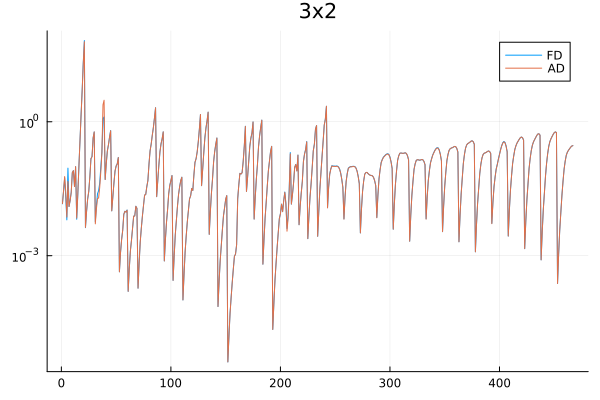

In [24]:
plot(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_FD)) ./ diag(meta_3x2.cov), label="FD", title="3x2")
plot!(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_AD)) ./ diag(meta_3x2.cov), yscale=:log10, label="AD")

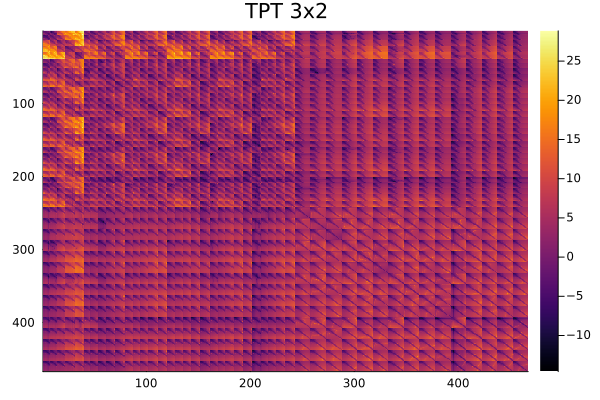

In [25]:
heatmap(log.(abs.((Cmod_3x2_AD .- meta_3x2.cov)./ meta_3x2.cov)), title="TPT 3x2", yflip=true)

## Save

In [26]:
using NPZ
npzwrite("covs/COSMODC2/dz_covs.npz",
        Dict(
        "wlwl_AD" => Cmod_wlwl_AD,
        "wlwl_FD" => Cmod_wlwl_FD,
        "gcgc_AD" => Cmod_gcgc_AD,
        "gcgc_FD" => Cmod_gcgc_FD,
        "3x2_AD" => Cmod_3x2_AD,
        "3x2_FD" => Cmod_3x2_FD))